<h2>Image Segmentation with CamVid</h2>

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.vision import *

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/labels'),
 PosixPath('/root/.fastai/data/camvid/images')]

In [4]:
path

PosixPath('/root/.fastai/data/camvid')

In [0]:
path_labels = path/'labels'
path_images = path/'images'

<h2>Data</h2>

In [6]:
fnames = get_image_files(path_images)
fnames[:3]

[PosixPath('/root/.fastai/data/camvid/images/0016E5_08097.png'),
 PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f02850.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_00450.png')]

In [7]:
label_names = get_image_files(path_labels)
label_names[:3]

[PosixPath('/root/.fastai/data/camvid/labels/Seq05VD_f01470_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0006R0_f01740_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0001TP_007980_P.png')]

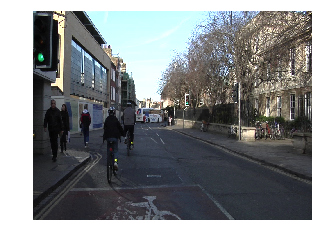

In [8]:
img_file = fnames[0]
img = open_image(img_file)
img.show(figsize=(5,5))

In [0]:
get_f_fun = lambda x : path_labels/f'{x.stem}_P{x.suffix}'

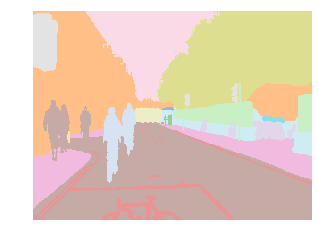

In [10]:
mask = open_mask(get_f_fun(img_file))
mask.show(figsize=(5,5))

In [11]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ..., 26, 26, 26],
          [ 4,  4,  4,  ..., 26, 26, 26],
          [ 4,  4,  4,  ..., 26, 26, 26],
          ...,
          [17, 10, 10,  ..., 17, 17, 17],
          [17, 17, 10,  ..., 17, 17, 17],
          [17, 17, 10,  ..., 17, 17, 17]]]))

In [12]:
codes = np.loadtxt(path/'codes.txt',dtype=str);
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

<h2>Datasets</h2>

In [0]:
size = 224
bs = 8

In [0]:
src = (SegmentationItemList.from_folder(path_images).split_by_fname_file(path/'valid.txt')
        .label_from_func(get_f_fun,classes=codes)
       )

In [0]:
data = (src.transform(get_transforms(),size=size,tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [16]:
data

ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: SegmentationLabelList
ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224)
Path: /root/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: SegmentationLabelList
ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224)
Path: /root/.fastai/data/camvid/images;

Test: None

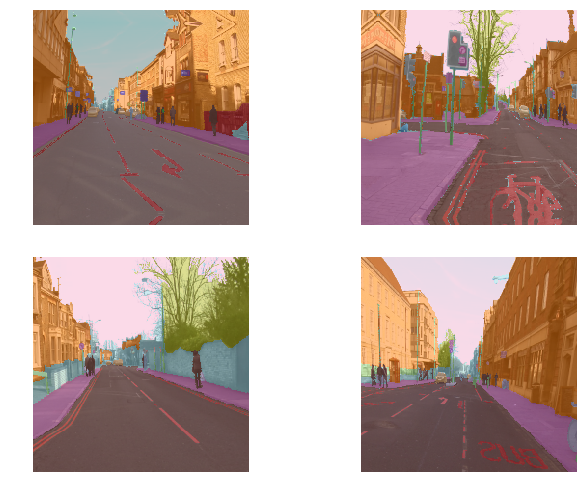

In [17]:
data.show_batch(2,figsize=(10,7))

<h2>Model</h2>

In [0]:
name2id = {v:k for k,v in enumerate(codes)}

In [19]:
name2id

{'Animal': 0,
 'Archway': 1,
 'Bicyclist': 2,
 'Bridge': 3,
 'Building': 4,
 'Car': 5,
 'CartLuggagePram': 6,
 'Child': 7,
 'Column_Pole': 8,
 'Fence': 9,
 'LaneMkgsDriv': 10,
 'LaneMkgsNonDriv': 11,
 'Misc_Text': 12,
 'MotorcycleScooter': 13,
 'OtherMoving': 14,
 'ParkingBlock': 15,
 'Pedestrian': 16,
 'Road': 17,
 'RoadShoulder': 18,
 'SUVPickupTruck': 22,
 'Sidewalk': 19,
 'SignSymbol': 20,
 'Sky': 21,
 'TrafficCone': 23,
 'TrafficLight': 24,
 'Train': 25,
 'Tree': 26,
 'Truck_Bus': 27,
 'Tunnel': 28,
 'VegetationMisc': 29,
 'Void': 30,
 'Wall': 31}

In [0]:
void_code = name2id['Void']

In [0]:
def acc_camvid(input, target):
  target = target.squeeze(1)
  mask = target != void_code
  return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics = acc_camvid

In [0]:
wd = 1e-2

In [24]:
learn = unet_learner(data, models.resnet50, metrics=metrics, wd = wd).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:00<00:00, 173015852.31it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-06
Min loss divided by 10: 3.63E-04


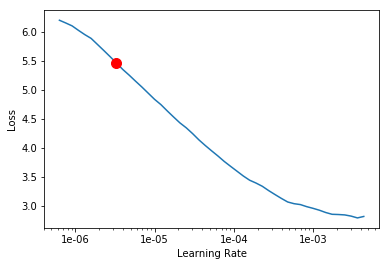

In [25]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [26]:
learn.fit_one_cycle(12, max_lr=0.000759)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.084996,0.794309,0.797453,01:38
1,0.767105,0.773585,0.820120,01:32
2,0.699119,0.528144,0.865005,01:31
3,0.585574,0.441771,0.885701,01:30
4,0.537222,0.422207,0.885037,01:30
5,0.472496,0.418382,0.889059,01:30
6,0.446101,0.411553,0.884078,01:30
7,0.400135,0.322304,0.909227,01:29
8,0.365972,0.322267,0.905020,01:30
9,0.335088,0.313217,0.909306,01:30
